# Assignment 2: Investigating New York Taxi data 2019 to 2021

Declan Stockdale

This notebook is an accompanyment to the handover report as part of the Big Data Engineering subject

### The first bit off data collection and cleanign has been performed and the files written to the azuse cluster. At various point largely in the business questions and the ML process, there is the option to jump straight in by loading the relevant cleaned files immeaditely. This is done to save time and effort if the cluster times out or save additional set up running the analysis daily.

# Setup environment

## Importing packages

In [0]:
# import pyspark and various packages
from pyspark.sql import SparkSession
# functions
import pyspark.sql.functions as F
# other functions
from pyspark.sql.functions import *
# change data types in schema
from pyspark.sql.types import IntegerType, DateType,FloatType,TimestampType,DecimalType,DoubleType
# add values to new column
from pyspark.sql.functions import lit

## Create spark session

In [0]:
# start instance
spark = SparkSession.builder \
        .appName('assignment2') \
        .getOrCreate()

## Connect to azure storage

In [0]:
# set variables for loading data from azure
storage_account_name = "utsdeclandb"
storage_account_access_key = "Ql3YOkpInOVtbzqgqLvmYIkzkplMKxU5q1qOD0LvUA8JQUIPK3hgfS53WzSac2BmJJ6QCCJDlFemcWRfCLvkag=="
blob_container_name = "assignment2"

## Mount storage

In [0]:
# mount in databricks
# try loop so it doesn't stop if its already mounted
try:
    dbutils.fs.mount(
      source = f'wasbs://{blob_container_name}@{storage_account_name}.blob.core.windows.net',
      mount_point = f'/mnt/{blob_container_name}/',
      extra_configs = {'fs.azure.account.key.' + storage_account_name + '.blob.core.windows.net': storage_account_access_key}
    )
except:
    print('Already mounted')

Already mounted


# Loading data

## Load in data from azure storage

In [0]:
# check if path file exists, already converted to parquet
if len(dbutils.fs.ls('/mnt/assignment2/output/yellow_taxi_df/')) < 90:
    # read all files with yellow in name
    df_yellow = spark.read.option("header", True).csv("/mnt/assignment2/csv_yellow/yellow*")
    df_yellow.write.parquet('/mnt/assignment2/output/yellow_taxi_df', mode='append')

# check if path file exists, already converted to parquet
if len(dbutils.fs.ls('/mnt/assignment2/output/green_taxi_df/')) < 13:
    # read all files with green in name
    df_green = spark.read.option("header", True).csv("/mnt/assignment2/csv_green/green*")
    df_green.write.parquet('/mnt/assignment2/output/green_taxi_df', mode='append')

## Load each taxi type into one large dataframe

In [0]:
# load datasets as aquet files into pyspark dataframes
df_yellow_taxi = spark.read.parquet("/mnt/assignment2/output/yellow_taxi_df/*.parquet")
#df_yellow_taxi.cache()

df_green_taxi = spark.read.parquet("/mnt/assignment2/output/green_taxi_df/*.parquet")
#df_green_taxi.cache()

## Count rows in each dataset

In [0]:
#df_yellow_taxi.count() # 124,048,218
#df_green_taxi.count() # 8,348,567
# total = (124,048,218+  8,348,567) = 132,396,785

# Investigating Schema

### Differences between schema

There appears to only be two additional column in the green taxi database with the column "trip_type": indicating 1- street hail or 2 from dispatch. The value can be altered by the driver but l'm assuming that is extremely rare. The second is "ehail_fee" which isn't mentioned in the data dictionary. 

The pick up and drop off columns have a slight difference in the name where yellow starts with a "t" and green starts with a "l". These will be changed to the same same for each dataset during the processing stages.

There is also no mention of the congestion surcharge in either data dictionary. In the yellow taxi data, values are mostly null. In the green taxi data, values are mostly 0. Will need to convert null values in yellow to 0.

### tidbits

1. mta_tax and improvemtn surcharge seems to not be applied for ratecode = 5 (negotiated fare) 

2. Outliers of 32 and 48 (one row of each exists for passenger count). 

3. All doubles with be converted to float to save memory

## Yellow taxi schema

In [0]:
# show yellow taxi schema
df_yellow_taxi.printSchema()

root
 |-- VendorID: string (nullable = true)
 |-- tpep_pickup_datetime: string (nullable = true)
 |-- tpep_dropoff_datetime: string (nullable = true)
 |-- passenger_count: string (nullable = true)
 |-- trip_distance: string (nullable = true)
 |-- RatecodeID: string (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: string (nullable = true)
 |-- DOLocationID: string (nullable = true)
 |-- payment_type: string (nullable = true)
 |-- fare_amount: string (nullable = true)
 |-- extra: string (nullable = true)
 |-- mta_tax: string (nullable = true)
 |-- tip_amount: string (nullable = true)
 |-- tolls_amount: string (nullable = true)
 |-- improvement_surcharge: string (nullable = true)
 |-- total_amount: string (nullable = true)
 |-- congestion_surcharge: string (nullable = true)



### Renaming timestamp columns columns

In [0]:
## Change pick up and drop off
## Also change tripdistance to be clearer on units

df_yellow_taxi_clean = df_yellow_taxi.\
    withColumnRenamed("tpep_pickup_datetime","pickup_timestamp").\
    withColumnRenamed("tpep_dropoff_datetime","dropoff_timestamp").\
    withColumnRenamed("trip_distance","trip_distance_miles")

### Change schema

In [0]:
# to timestamp: tpep_pickup_datetime, tpep_dropoff_datetime
# to integer: VendorID, passenger_count, RatecodeID, PULocationID, DOLocationID, payment_type
# to float: trip_distance, fare_amount, extra, tip_amount, tolls_amount, total_amount, congestion_surcharge
# added taxi_type 'yellow', ehail_fee and trip_type to match columns in green schema

df_yellow_taxi_clean = df_yellow_taxi_clean.\
    withColumn("VendorID", F.col("VendorID").astype(IntegerType())).\
    withColumn("pickup_timestamp",F.col("pickup_timestamp").astype(TimestampType())).\
    withColumn("dropoff_timestamp",F.col("dropoff_timestamp").astype(TimestampType())).\
    withColumn("passenger_count", F.col("passenger_count").astype(IntegerType())).\
    withColumn("trip_distance_miles", F.col("trip_distance_miles").astype(FloatType())).\
    withColumn("RatecodeID", F.col("RatecodeID").astype(IntegerType())).\
    withColumn("PULocationID", F.col("PULocationID").astype(IntegerType())).\
    withColumn("DOLocationID", F.col("DOLocationID").astype(IntegerType())).\
    withColumn("payment_type", F.col("payment_type").astype(IntegerType())).\
    withColumn("fare_amount", F.col("fare_amount").astype(FloatType())).\
    withColumn("extra", F.col("extra").astype(FloatType())).\
    withColumn("mta_tax", F.col("mta_tax").astype(FloatType())).\
    withColumn("tip_amount", F.col("tip_amount").astype(FloatType())).\
    withColumn("tolls_amount", F.col("tolls_amount").astype(FloatType())).\
    withColumn("improvement_surcharge", F.col("improvement_surcharge").astype(FloatType())).\
    withColumn("total_amount", F.col("total_amount").astype(FloatType())).\
    withColumn("congestion_surcharge", F.col("congestion_surcharge").astype(FloatType())).\
    withColumn("ehail_fee", lit(0.00)) .\
    withColumn("trip_type", lit(0)).\
    withColumn("taxi_type", lit("yellow"))

In [0]:
df_yellow_taxi_clean.printSchema()

root
 |-- VendorID: integer (nullable = true)
 |-- pickup_timestamp: timestamp (nullable = true)
 |-- dropoff_timestamp: timestamp (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- trip_distance_miles: float (nullable = true)
 |-- RatecodeID: integer (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- payment_type: integer (nullable = true)
 |-- fare_amount: float (nullable = true)
 |-- extra: float (nullable = true)
 |-- mta_tax: float (nullable = true)
 |-- tip_amount: float (nullable = true)
 |-- tolls_amount: float (nullable = true)
 |-- improvement_surcharge: float (nullable = true)
 |-- total_amount: float (nullable = true)
 |-- congestion_surcharge: float (nullable = true)
 |-- ehail_fee: double (nullable = false)
 |-- trip_type: integer (nullable = false)
 |-- taxi_type: string (nullable = false)



## Green taxi schema

In [0]:
# show green taxi schema
df_green_taxi.printSchema()

root
 |-- VendorID: string (nullable = true)
 |-- lpep_pickup_datetime: string (nullable = true)
 |-- lpep_dropoff_datetime: string (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- RatecodeID: string (nullable = true)
 |-- PULocationID: string (nullable = true)
 |-- DOLocationID: string (nullable = true)
 |-- passenger_count: string (nullable = true)
 |-- trip_distance: string (nullable = true)
 |-- fare_amount: string (nullable = true)
 |-- extra: string (nullable = true)
 |-- mta_tax: string (nullable = true)
 |-- tip_amount: string (nullable = true)
 |-- tolls_amount: string (nullable = true)
 |-- ehail_fee: string (nullable = true)
 |-- improvement_surcharge: string (nullable = true)
 |-- total_amount: string (nullable = true)
 |-- payment_type: string (nullable = true)
 |-- trip_type: string (nullable = true)
 |-- congestion_surcharge: string (nullable = true)



### Rename columns

In [0]:
## Change pick up and drop off
## Also change trip distance to be clearer on units

df_green_taxi_clean = df_green_taxi.\
    withColumnRenamed("lpep_pickup_datetime","pickup_timestamp").\
    withColumnRenamed("lpep_dropoff_datetime","dropoff_timestamp").\
    withColumnRenamed("trip_distance","trip_distance_miles")

### Reorder green taxi columns so they match with yellow taxi for easier merging.

In [0]:
# reorder columns by name

df_green_taxi_clean = df_green_taxi_clean.select("VendorID", "pickup_timestamp", "dropoff_timestamp", "passenger_count", "trip_distance_miles" , "RatecodeID",  "store_and_fwd_flag",  "PULocationID",  "DOLocationID", "payment_type",  "fare_amount",  "extra",  "mta_tax",  "tip_amount",  "tolls_amount", "improvement_surcharge", "total_amount",  "congestion_surcharge","ehail_fee","trip_type")

### Change schema

In [0]:
# to timestamp: tpep_pickup_datetime, tpep_dropoff_datetime
# to integer: VendorID, passenger_count, RatecodeID, PULocationID, DOLocationID, payment_type
# to float: trip_distance, fare_amount, extra, tip_amount, tolls_amount, total_amount, congestion_surcharge
# added taxi_type 'green'

df_green_taxi_clean = df_green_taxi_clean.\
    withColumn("VendorID", F.col("VendorID").astype(IntegerType())).\
    withColumn("pickup_timestamp",F.col("pickup_timestamp").astype(TimestampType())).\
    withColumn("dropoff_timestamp",F.col("dropoff_timestamp").astype(TimestampType())).\
    withColumn("passenger_count", F.col("passenger_count").astype(IntegerType())).\
    withColumn("trip_distance_miles", F.col("trip_distance_miles").astype(FloatType())).\
    withColumn("RatecodeID", F.col("RatecodeID").astype(IntegerType())).\
    withColumn("PULocationID", F.col("PULocationID").astype(IntegerType())).\
    withColumn("DOLocationID", F.col("DOLocationID").astype(IntegerType())).\
    withColumn("payment_type", F.col("payment_type").astype(IntegerType())).\
    withColumn("fare_amount", F.col("fare_amount").astype(FloatType())).\
    withColumn("extra", F.col("extra").astype(FloatType())).\
    withColumn("mta_tax", F.col("mta_tax").astype(FloatType())).\
    withColumn("tip_amount", F.col("tip_amount").astype(FloatType())).\
    withColumn("tolls_amount", F.col("tolls_amount").astype(FloatType())).\
    withColumn("improvement_surcharge", F.col("improvement_surcharge").astype(FloatType())).\
    withColumn("total_amount", F.col("total_amount").astype(FloatType())).\
    withColumn("congestion_surcharge", F.col("congestion_surcharge").astype(FloatType())).\
    withColumn("ehail_fee", F.col("ehail_fee").astype(DoubleType())).\
    withColumn("taxi_type", lit("green")) 

### Look at schema after alterations

In [0]:
# show green taxi schema
#df_green_taxi_clean.printSchema()

## Merge datasets as they now have same schema

In [0]:
df_taxi_merged = df_yellow_taxi_clean.union(df_green_taxi_clean)

In [0]:
# check schema is the same, it is
df_taxi_merged.printSchema()

root
 |-- VendorID: integer (nullable = true)
 |-- pickup_timestamp: timestamp (nullable = true)
 |-- dropoff_timestamp: timestamp (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- trip_distance_miles: float (nullable = true)
 |-- RatecodeID: integer (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- payment_type: integer (nullable = true)
 |-- fare_amount: float (nullable = true)
 |-- extra: float (nullable = true)
 |-- mta_tax: float (nullable = true)
 |-- tip_amount: float (nullable = true)
 |-- tolls_amount: float (nullable = true)
 |-- improvement_surcharge: float (nullable = true)
 |-- total_amount: float (nullable = true)
 |-- congestion_surcharge: float (nullable = true)
 |-- ehail_fee: double (nullable = true)
 |-- trip_type: string (nullable = true)
 |-- taxi_type: string (nullable = false)



# Filter out illogical values

As the dataset is large and it will take a considerable amount of time to run any analysis on it, l'm goin to initially filter out any values which I think are illogical or are restrited in the data dictionary

#### Function for removing illogical values
Logic around timestamp is to remove values that started before 12am on Jan 1 2019  even if the trip ended after that date.

What has been filtered (alphabeticaly)


congestion_surcharge - is set to 0 when null as its not in the yellow_taxi_df 

DOLocationID - set between 1 and 264 as per data dicitonary (265 and 264 are unknown so they are given the same value)

dropoff_timestamp - set between midnight 1 January 2019 and 1 August 2021

extra - set between 0 and 60 (high extras possibly due to airport associated fares)

fare_amount - Set minimum as $2.50 which is the minimum taxi fare dictated by NYC taxis

improvement_surcharge - set beteen 0 and 0.60 (0.30 seems to be minimum mandated but there are alot of fares with 0.60 so I left it in)

mta_tax - set between 0 and 0.50 which appears to be a mandated fare

passenger_count - Fixed to between 1 and 9

pickup_timestamp - set between midnight 1 January 2019 and 1 August 2021 (some values start new years eve 2018. These are removed as I only considered trips that started in 2019.)

PULocationID - set between 1 and 264 as per data dicitonary (265 and 264 are unknown so they are given the same value)

RatecodeID - Set between 1 and 6 per data dicitonary

tip_amount - removed negative values and set maximum tip to 50% of total_fare (seems reasonable to not pay such a high tip percentage)

trip_distane_miles - Fixed between 0 and 766.5 (values larger appear to have same drop off and pick up locations)

tolls_amount - set between 0 and 100

total_amount - Set to 2.50 minimum (no extra fees except mandated minimum fare)

VendorId - set between 1 and 2 as per data dicitonary


Duplicates were also removed

In [0]:
def remove_illogical_values(dataframe):
    
    # copy dataframe
    filtered_df = dataframe
 
    # congestion_surcharge - Fix null congestion_surcharge to 0
    filtered_df = filtered_df.na.fill(value=0,subset=["congestion_surcharge"])
    
    # DOLocationID - Remove any dropoff locations not between 1 and 265
    filtered_df = filtered_df.filter(F.col("DOLocationID").between(1,265)) 
                                         
    # DOLocationID - Both 265 and 264 are unknown, change 265 to 264 
    filtered_df = filtered_df.withColumn('DOLocationID',when(filtered_df.DOLocationID == 265,264).otherwise(filtered_df.DOLocationID))
    
    # dropoff_timestamp - Remove any date of 2018 or after July 31st
    filtered_df = filtered_df.filter(F.col("dropoff_timestamp").between('2019-01-01 00:00:00','2021-08-01 00:00:00'))
    
    # extra - Remove extra outside range 0 to 60.00
    filtered_df = filtered_df.filter(F.col("extra").between(0,60.00)) 
                                         
    # fare_amount - Remove any fare less than minimum of $2.50 dictated by taxis
    filtered_df = filtered_df[filtered_df.fare_amount >= 2.50] 
    
    # improvement_surcharge - Remove improvement_surcharge more than $0.60
    filtered_df = filtered_df.filter(F.col("improvement_surcharge").between(0,0.60))    
    
    # mta_tax - Remove mta_tax outisde of 0 - 1.50 range
    filtered_df = filtered_df.filter(F.col("mta_tax").between(0,0.50))    
    
    # passenger_count - Remove 0 or negative passenger count also remove greater than 9
    filtered_df = filtered_df.filter(F.col("passenger_count").between(1,9))  

    # pickup_timestamp - Remove any date of 2018 or after July 31st
    filtered_df = filtered_df.filter(F.col("pickup_timestamp").between('2019-01-01 00:00:00','2021-08-01 00:00:00'))
    
    # PULocationID - Remove any pickup locations not between 1 and 265
    filtered_df = filtered_df.filter(F.col("PULocationID").between(1,265)) 
    
    # PULocationID - Both 265 and 264 are unknown, change 265 to 264 
    filtered_df = filtered_df.withColumn('PULocationID',when(filtered_df.DOLocationID == 265,264).otherwise(filtered_df.PULocationID))
    
     # RatecodeID - Fix RatecodeID out of range
    filtered_df = filtered_df.filter(F.col("RatecodeID").between(1,6)) 
  
    # tip_amount - Remove negative tips
    filtered_df = filtered_df[filtered_df.tip_amount >= 0]
    # tip_amount - Remove tip_amount if more than 50% of total_amount
    filtered_df = filtered_df[filtered_df.tip_amount < (0.50*filtered_df.total_amount)]
    
    # tolls_amount - Remove negative tolls_amount
    filtered_df = filtered_df.filter(F.col("tolls_amount").between(0,100.00))    
  
    # total_amount - Remove negative total_amount
    filtered_df = filtered_df[filtered_df.total_amount > 2.50]
  
    
    # trip_distance_miles - Remove 0 or negative distance trip_distance_miles
    filtered_df = filtered_df[filtered_df.trip_distance_miles >0] 
    filtered_df = filtered_df.filter(F.col("trip_distance_miles").between(0,766.5))  
    
    # VendorID - Fix VendorID out of range
    filtered_df = filtered_df.filter(F.col("VendorID").between(1,2)) 
    
    # dropDuplicates - remove duplicate rows
    filtered_df = filtered_df.dropDuplicates()
    
    return filtered_df

In [0]:
# Run the filter function above
df_taxi_merged_filtered = remove_illogical_values(df_taxi_merged)


### Count how many rows were removed and remain

Before filter 132396785
after  filter 124879680

columns removed 7517105

In [0]:
#original_df_count = 132396785 #df_taxi_merged.count()
#after_filter_count = df_taxi_merged_filtered.count()

#print('after', after_filter_count) # 124880736
#print('columns removed', original_df_count-after_filter_count) #7,516,049

## Investigate pick up and drop off locations

The data dictionary only as values from 1 to 265 so remove anything thats not in this range

I noticed that a substantial number of rows have the same pick up and drop off. Most of these seem short and do attract the minimum fare of $2.50 but some are around $50+ dollars which I cann only assume is the passenger telling the driver to wait around while they do something. Counting the rows with the same pick up and drop off IDs give a value of 7701314 rows. l'm going to leave them in the dataset

# Converting and creating columns

### Convert trip_distance_miles from miles to kilometres

In [0]:
# Change trip_distance from miles to km multiply by 1.608
df_taxi_merged_filtered = df_taxi_merged_filtered.withColumn("trip_distance_km",F.col("trip_distance_miles")*1.608)

# Round to 2 dp after conversion
df_taxi_merged_filtered = df_taxi_merged_filtered.withColumn("trip_distance_km", F.round(df_taxi_merged_filtered["trip_distance_km"], 2))

### Drop trip_distance_miles column

In [0]:
df_taxi_merged_filtered = df_taxi_merged_filtered.drop("trip_distance_miles") 

### Add year, month and day of week columns using pickup_timestamp

In [0]:
# add date columns for year, month, day of week
df_taxi_merged_filtered = df_taxi_merged_filtered.withColumn("year", year(col("pickup_timestamp"))).\
    withColumn("month", month(col("pickup_timestamp"))).\
    withColumn("day_of_week", dayofweek(col("pickup_timestamp"))).\
    withColumn("24_hour", hour(col("pickup_timestamp")))

### Convert pick up and drop off to unix timestamp and calculate time of trip by subtracting drop off from pickup

In [0]:
# get time of trip length unix_timestamp
df_taxi_merged_filtered = df_taxi_merged_filtered.\
    withColumn("pickup_ts_unix", unix_timestamp(col("pickup_timestamp"))).\
    withColumn("dropoff_ts_unix", unix_timestamp(col("dropoff_timestamp")))

df_taxi_merged_filtered = df_taxi_merged_filtered.withColumn("time_of_trip_seconds", (F.col("dropoff_ts_unix")-F.col("pickup_ts_unix")))

### Drop unix timestamp columns are they are no longer neeed

Relevant information is encoded in other columns

In [0]:
df_taxi_merged_filtered = df_taxi_merged_filtered.drop("pickup_ts_unix","dropoff_ts_unix") 

## Calculate average speed in km/h to 2 dp

In [0]:
# speed in km/h divide trip length by trip time  - multiply by 3600 (3600 seconds in an hour)to get speed in km/h
df_taxi_merged_filtered = df_taxi_merged_filtered.withColumn("speed_km_h", (F.col("trip_distance_km")*3600/F.col("time_of_trip_seconds")))

# round answer
df_taxi_merged_filtered = df_taxi_merged_filtered.withColumn("speed_km_h", F.round(df_taxi_merged_filtered["speed_km_h"], 2))

### Final clean based on new columns

There are a few rows where the calculated speed is incredibly slow such as less than 1 km/h. These columns all have extremely long trip times of at least 58363 equating to 16 hours. These will be removed as well. l've set the lower limit on trip time to be 30 seconds as shorter trips don't seem reasonable.

Some speed values are enormous and obviously suspect but there are also some that are difficult to tell if they are valid or not. To draw a distinction l'll be using the speed limit of New York state of 105 km/h [https://en.wikipedia.org/wiki/Speed_limits_in_the_United_States] rounded up to 120 km/h because taxis aren't always known for always obeying the speed limit as fares are sometimes paid by distance not time. I've set the lower limit to 5km which is the average human walking speed https://en.wikipedia.org/wiki/Walking#:~:text=Although%20walking%20speeds%20can%20vary,miles%20per%20hour%20(mph).

In [0]:
# fix exceedingly long trip time Remove trips less than 30 seconds because it seems to short
df_taxi_merged_filtered = df_taxi_merged_filtered.filter(F.col("time_of_trip_seconds").between(30,58363))

# Remove rows above 120km/h and rows below 5km//h -> average walking speed accordint to wikipedia
df_taxi_merged_filtered = df_taxi_merged_filtered.filter(F.col("speed_km_h").between(5,120))

df_taxi_merged_filtered.cache()

Out[285]: DataFrame[VendorID: int, pickup_timestamp: timestamp, dropoff_timestamp: timestamp, passenger_count: int, RatecodeID: int, store_and_fwd_flag: string, PULocationID: int, DOLocationID: int, payment_type: int, fare_amount: float, extra: float, mta_tax: float, tip_amount: float, tolls_amount: float, improvement_surcharge: float, total_amount: float, congestion_surcharge: float, ehail_fee: double, trip_type: string, taxi_type: string, trip_distance_km: double, year: int, month: int, day_of_week: int, 24_hour: int, time_of_trip_seconds: bigint, speed_km_h: double]

## Count of rows throughout the filtering process

The as imported df_yellow_taxi had 124,048,218 rows

The as imported df_green_taxi had 8,348,567 rows

The total number of rows was 132,396,785 before any rows were removed

The first filtering process removed 7,517,105 rows with a remaining 124,879,680 rows left

After creating new columns and filtering based on them, 1,764,636 rows were removed 

Leaving a final row count of 123,115,044

In [0]:
#count final amount of rows 124466963 
#final_clean_count = df_taxi_merged_filtered.count()
#print('final_clean_count', final_clean_count)
#print('rows removed = ', 124879680-final_clean_count)

final_clean_count 123115044
rows removed =  1764636


#### Final clean up schema for ehail_fee and speed_km_h from double to float and trip_type from string to Integer

In [0]:
# fixing up ehail_fee and speed_km_h to float and trip type to integer

df_taxi_merged_filtered = df_taxi_merged_filtered.\
    withColumn("ehail_fee", F.col("ehail_fee").astype(FloatType())).\
    withColumn("trip_type", F.col("trip_type").astype(IntegerType())).\
    withColumn("speed_km_h", F.col("speed_km_h").astype(FloatType()))

### Sanity check that all values are as expected (no null, no nan, empty string)

In [0]:
#from pyspark.sql.functions import col,isnan,when,count
#expected_df = df_taxi_merged_filtered.select([count(when(col(c).contains('None') | \
#                            col(c).contains('NULL') | \
#                            (col(c) == '' ) | \
#                            col(c).isNull() | \
#                            isnan(c), c 
#                           )).alias(c)
#                    for c in df_taxi_merged_filtered.columns])
#expected_df.show()

### Write merged dataframe to parquet

In [0]:
df_taxi_merged_filtered.write.parquet('/mnt/assignment2/final_merged_data/parquet') # took 1.5 hours

### Clear cache to free up as much memory as possible now that working dataframe has been saved 
#### Start here on reboot

In [0]:
spark.catalog.clearCache()

#### Read back merged dataframe as parquet

In [0]:
df_taxi_merged_filtered = spark.read.parquet('/mnt/assignment2/final_merged_data/parquet/*')

In [0]:
#yellow_count = df_taxi_merged_filtered.filter(df_taxi_merged_filtered.taxi_type == "yellow").count() #117939987
#green_count = df_taxi_merged_filtered.filter(df_taxi_merged_filtered.taxi_type == "green").count() #6858789

#print('yellow_count', yellow_count) #117613061
#print('green_count', green_count) #green_count

yellow_count 117613061
green_count 6853902


# Business Questions

## First we need to write the filtered dataframe to a table to allow for sql queries

In [0]:
# create smaller df for faster testing of query

#df_taxi_merged_filtered_small=df_taxi_merged_filtered.sample(0.00001)
#df_taxi_merged_filtered_small.createOrReplaceTempView("taxi_df_small")

# Use whole datset for final run
df_taxi_merged_filtered.createOrReplaceTempView("taxi_df")

## Q1.	For each year and month:

### a)	What was the total number of trips?

In [0]:
# Each row is a unique trip so if we count the number of rows we get the answer
'''
SELECT Count(*) AS Number_of_unique_trips
FROM   taxi_df 
'''

#spark.sql("SELECT COUNT(*) as Number_of_unique_trips FROM taxi_df").show() #124798776 
spark.sql("SELECT COUNT(*) as Number_of_unique_trips FROM taxi_df").show() #124798776 

+----------------------+
|Number_of_unique_trips|
+----------------------+
|             123115044|
+----------------------+



### b)	Which day of week (e.g. monday, tuesday, etc..) had the most trips?

In [0]:
# The days of the week are stored as integers with 1 = 'Sunday' 2 = 'Monday' etc. Using CASE we can give them the day of the week in English instead of a number. 
# To get result, coutn all rows and group by day_of_week. Order by result and limit to 1 to get answer

# Sunday = 1 Accoring to pyspark documentation
'''
SELECT day_of_week,
       CASE day_of_week
         WHEN 1 THEN 'Sunday'
         WHEN 2 THEN 'Monday'
         WHEN 3 THEN 'Tuesday'
         WHEN 4 THEN 'Wednesday'
         WHEN 5 THEN 'Thursday'
         WHEN 6 THEN 'Friday'
         WHEN 7 THEN 'Saturday'
       end,
       Count(*) AS Trips_per_day
FROM   taxi_df
GROUP  BY day_of_week
ORDER  BY trips_per_day DESC
LIMIT  1 
'''


spark.sql("SELECT day_of_week, CASE day_of_week WHEN 1 THEN 'Sunday' WHEN 2 THEN 'Monday' WHEN 3 THEN 'Tuesday'  WHEN 4 THEN 'Wednesday'      WHEN 5 THEN 'Thursday' WHEN 6 THEN 'Friday' WHEN 7 THEN 'Saturday' END,  COUNT(*) as Trips_per_day FROM taxi_df GROUP BY day_of_week ORDER BY Trips_per_day DESC LIMIT 1").show()

day_of_week,CASE WHEN (day_of_week = 1) THEN Sunday WHEN (day_of_week = 2) THEN Monday WHEN (day_of_week = 3) THEN Tuesday WHEN (day_of_week = 4) THEN Wednesday WHEN (day_of_week = 5) THEN Thursday WHEN (day_of_week = 6) THEN Friday WHEN (day_of_week = 7) THEN Saturday END,Trips_per_day
5,Thursday,19166260


In [0]:
# plot number of trips each hour across entire dataframe

'''
SELECT 24_hour,
       Count(24_hour) AS Num_trips
FROM   taxi_df
GROUP  BY 24_hour
ORDER  BY 24_hour ASC 
'''

display(spark.sql("SELECT 24_hour, COUNT(24_hour) as Num_trips FROM taxi_df GROUP BY 24_hour ORDER BY 24_hour ASC  "))#.show()

24_hour,Num_trips
0,3313657
1,2264399
2,1547073
3,1075599
4,828979
5,1008530
6,2424067
7,4349092
8,5632445
9,5792968


### c) Which hour of the day had the most trips?

In [0]:
# Hours is in 24 hour format. 
# By grouping by 24_hour column and order in descending order and finally limit the answer to 1 we get the day hour with the most trips 

'''
SELECT 24_hour,
       Count(*) AS number_trips
FROM   taxi_df
GROUP  BY 24_hour
ORDER  BY number_trips DESC 
'''

spark.sql("SELECT 24_hour, COUNT(*) as number_trips FROM taxi_df GROUP BY 24_hour ORDER BY number_trips DESC").show()

+-------+------------+
|24_hour|number_trips|
+-------+------------+
|     18|     8328474|
|     17|     7722257|
|     19|     7660937|
|     15|     7345020|
|     14|     7242781|
|     16|     6983770|
|     13|     6794193|
|     20|     6747293|
|     12|     6680089|
|     21|     6508282|
|     11|     6263958|
|     22|     5969997|
|     10|     5945432|
|      9|     5792968|
|      8|     5632445|
|     23|     4685752|
|      7|     4349092|
|      0|     3313657|
|      6|     2424067|
|      1|     2264399|
+-------+------------+
only showing top 20 rows



### d) What was the average number of passengers?

In [0]:
# use Average function on passeger_count column to find average number of passengers per trip
# Rounded to 2 dp

'''
SELECT Round(Avg(passenger_count), 2) AS Average_number_of_Passengers_per_trip
FROM   taxi_df 
'''
spark.sql("SELECT ROUND(AVG(passenger_count),2) as Average_number_of_Passengers_per_trip FROM taxi_df").show()

+-------------------------------------+
|Average_number_of_Passengers_per_trip|
+-------------------------------------+
|                                 1.55|
+-------------------------------------+



### e) What was the average amount paid per trip (using total_amount)?

In [0]:
# use Average function on total_amount column to find average total trip fare
# Rounded to 2 dp

'''
SELECT Round(Avg(total_amount), 2) AS Avg_total_amount_per_trip
FROM   taxi_df 
'''

spark.sql("SELECT ROUND(AVG(total_amount),2) as Avg_total_amount_per_trip FROM taxi_df").show()

+-------------------------+
|Avg_total_amount_per_trip|
+-------------------------+
|                    18.49|
+-------------------------+



### f) What was the average amount paid per passenger (using total_amount)?

In [0]:
# Sum total_amount divided by the sum of the passenger_count column to get average total fare per passenger

'''
SELECT Round(( Sum(total_amount) / Sum(passenger_count) ), 2) AS
       avg_total_fare_per_passenger
FROM   taxi_df 
'''
spark.sql("SELECT ROUND((SUM(total_amount)/SUM(passenger_count)),2) as avg_total_fare_per_passenger FROM taxi_df").show()

+----------------------------+
|avg_total_fare_per_passenger|
+----------------------------+
|                       11.94|
+----------------------------+



## Question 2. For each taxi colour (yellow and green):

### a) What was the average, median, minimum and maximum trip duration in seconds?

In [0]:
# Avererage, Min and Max function used as well as finding 50% percentile answer using percentlile_approx function to get median on time_of_trip_seconds
# Group by taxi_type to get results for green and yellow taxis seperately 

'''
SELECT taxi_type,
       Percentile_approx(time_of_trip_seconds, 0.5) AS median_trip_time_seconds,
       Min(time_of_trip_seconds)                    AS min_trip_time_seconds,
       Max(time_of_trip_seconds)                    AS max_trip_time_seconds,
       Round(Avg(time_of_trip_seconds), 2)          AS avg_trip_time_seconds
FROM   taxi_df
GROUP  BY taxi_type 
'''


spark.sql("SELECT taxi_type, percentile_approx(time_of_trip_seconds, 0.5) as median_trip_time_seconds, MIN(time_of_trip_seconds) as min_trip_time_seconds, MAX(time_of_trip_seconds) as max_trip_time_seconds, ROUND(AVG(time_of_trip_seconds),2) as avg_trip_time_seconds FROM taxi_df GROUP BY taxi_type").show()


+---------+------------------------+---------------------+---------------------+---------------------+
|taxi_type|median_trip_time_seconds|min_trip_time_seconds|max_trip_time_seconds|avg_trip_time_seconds|
+---------+------------------------+---------------------+---------------------+---------------------+
|    green|                     664|                   30|                57071|                876.6|
|   yellow|                     654|                   30|                57987|               836.87|
+---------+------------------------+---------------------+---------------------+---------------------+



### b) What was the average, median, minimum and maximum trip distance in km?

In [0]:
# Avererage, Min and Max function used as well as finding 50% percentile answer using percentlile_approx function to get median on trip_distance_km
# Group by taxi_type too get results for green and yellow taxis seperately

'''
SELECT taxi_type,
       Percentile_approx(trip_distance_km, 0.5) AS median_trip_distance_km,
       Min(trip_distance_km)                    AS min_trip_distance_km,
       Max(trip_distance_km)                    AS max_trip_distance_km,
       Round(Avg(trip_distance_km), 2)          AS avg_trip_distance_km
FROM   taxi_df
GROUP  BY taxi_type  
'''

spark.sql("SELECT taxi_type, percentile_approx(trip_distance_km, 0.5) as median_trip_distance_km, MIN(trip_distance_km) as min_trip_distance_km, MAX(trip_distance_km) as max_trip_distance_km, ROUND(AVG(trip_distance_km),2) as avg_trip_distance_km FROM taxi_df GROUP BY taxi_type").show()

+---------+-----------------------+--------------------+--------------------+--------------------+
|taxi_type|median_trip_distance_km|min_trip_distance_km|max_trip_distance_km|avg_trip_distance_km|
+---------+-----------------------+--------------------+--------------------+--------------------+
|    green|                   3.06|                0.05|              829.55|                5.05|
|   yellow|                   2.72|                0.05|              710.09|                4.78|
+---------+-----------------------+--------------------+--------------------+--------------------+



###  c) What was the average, median, minimum and maximum speed in km per hour?

In [0]:
# Avererage, Min and Max function used as well as finding 50% percentile answer using percentlile_approx function to get median on speed_km_h
# Group by taxi_type too get results for green and yellow taxis seperately

'''
SELECT taxi_type,
       Percentile_approx(speed_km_h, 0.5) AS median_speed_km_h,
       Min(speed_km_h)                    AS min_speed_km_h,
       Max(speed_km_h)                    AS max_speed_km_h,
       Round(Avg(speed_km_h), 2)          AS avg_speed_km_h
FROM   taxi_df
GROUP  BY taxi_type 
'''

spark.sql("SELECT taxi_type, percentile_approx(speed_km_h, 0.5) as median_speed_km_h, MIN(speed_km_h) as min_speed_km_h, MAX(speed_km_h) as max_speed_km_h, ROUND(AVG(speed_km_h),2) as avg_speed_km_h FROM taxi_df GROUP BY taxi_type").show()

+---------+-----------------+--------------+--------------+--------------+
|taxi_type|median_speed_km_h|min_speed_km_h|max_speed_km_h|avg_speed_km_h|
+---------+-----------------+--------------+--------------+--------------+
|    green|            17.42|           5.0|        119.85|         19.51|
|   yellow|             16.4|           5.0|         120.0|         18.79|
+---------+-----------------+--------------+--------------+--------------+



## Question 3 What was the percentage of trips where the driver received tips?

In [0]:
# Using subquery
# Query to count all rows, then a second query to find only rows where the tip amount was greater than 0
# Divide the result and multiply by 100 to get percentage

'''
SELECT Round(100 * ( Count(tip_amount) / (SELECT Count(tip_amount)
                                          FROM   taxi_df) ), 2) AS
       Percentage_of_tips
FROM   taxi_df
WHERE  tip_amount > 0 
'''

spark.sql("SELECT ROUND(100* (COUNT(tip_amount) / (SELECT COUNT(tip_amount) FROM  taxi_df)),2) as Percentage_of_tips FROM taxi_df where tip_amount > 0 ").show()

+------------------+
|Percentage_of_tips|
+------------------+
|              69.0|
+------------------+



## Question 4. For trips where the driver received tips, what was the percentage where the driver received tips of at least $10.

In [0]:
# First query counts the number of rows with tip_mount >= $10 then that vaue is divided by counting all rows with tip_amount > 0. Result is multiplied by 100 to get percentage
# Rounded to 2 dp
'''
SELECT Round(100 * Count(tip_amount) / (SELECT Count(tip_amount)
                                        FROM   taxi_df
                                        WHERE  tip_amount > 0), 2) AS
       Percentage_of_tips_over_10
FROM   taxi_df
WHERE  tip_amount >= 10 
'''

spark.sql("SELECT ROUND(100* COUNT(tip_amount) / (SELECT COUNT(tip_amount) FROM  taxi_df WHERE tip_amount > 0 ),2) as Percentage_of_tips_over_10 FROM taxi_df where tip_amount >= 10 ").show()

+--------------------------+
|Percentage_of_tips_over_10|
+--------------------------+
|                      3.31|
+--------------------------+



## Question 5 Classify each trip into bins of durations:

#### a) Under 5 mins
#### b) From 5 mins to 10 mins
#### c) From 10 mins to 20mins
#### d) From 20 mins to 30 mins
#### e) At least 30 mins

In [0]:
# Count number of trips
'''
SELECT Count(CASE
               WHEN time_of_trip_seconds < 5 * 60 THEN 1
             END) AS 0_to_5,
       Count(CASE
               WHEN time_of_trip_seconds >= 5 * 60
                    AND time_of_trip_seconds < 10 * 60 THEN 1
             END) AS 5_to_10,
       Count(CASE
               WHEN time_of_trip_seconds >= 10 * 60
                    AND time_of_trip_seconds < 20 * 60 THEN 1
             END) AS 10_to_20,
       Count(CASE
               WHEN time_of_trip_seconds >= 20 * 60
                    AND time_of_trip_seconds < 30 * 60 THEN 1
             END) AS 20_to_30,
       Count(CASE
               WHEN time_of_trip_seconds >= 30 * 60 THEN 1
             END) AS at_least_30
FROM   taxi_df AS Duration_bins 
'''

spark.sql("SELECT  count(CASE WHEN time_of_trip_seconds < 5*60 THEN 1 END) AS 0_to_5, count(CASE WHEN time_of_trip_seconds >= 5*60 AND time_of_trip_seconds < 10*60 THEN 1 END) AS 5_to_10, count(CASE WHEN time_of_trip_seconds >= 10*60 AND time_of_trip_seconds < 20*60 THEN 1 END) AS 10_to_20, count(CASE WHEN time_of_trip_seconds >= 20*60 AND time_of_trip_seconds < 30*60 THEN 1 END) AS 20_to_30, count(CASE WHEN time_of_trip_seconds >= 30*60  THEN 1 END) AS at_least_30 FROM taxi_df AS Duration_bins").show()


+--------+--------+--------+--------+-----------+
|  0_to_5| 5_to_10|10_to_20|20_to_30|at_least_30|
+--------+--------+--------+--------+-----------+
|18129727|37542424|43007467|14803929|    9631497|
+--------+--------+--------+--------+-----------+



### a) Average speed per bin trip

In [0]:
# count number of trips in each 

'''
SELECT Round(Avg(speed_km_h), 2) AS Average_speed_kmh,
       CASE
         WHEN ( time_of_trip_seconds < 5 * 60 ) THEN '0_to_5'
         WHEN ( time_of_trip_seconds >= 5 * 60
                AND time_of_trip_seconds < 10 * 60 ) THEN '5_to_10'
         WHEN ( time_of_trip_seconds >= 10 * 60
                AND time_of_trip_seconds < 20 * 60 ) THEN '10_to_20'
         WHEN ( time_of_trip_seconds >= 20 * 60
                AND time_of_trip_seconds < 30 * 60 ) THEN '20_to_30'
         WHEN ( time_of_trip_seconds >= 30 * 60 ) THEN 'at_least_30'
       END                       AS Duration_bin
FROM   taxi_df
GROUP  BY duration_bin 
'''

spark.sql("SELECT ROUND(AVG(speed_km_h),2) as Average_speed_kmh, CASE WHEN (time_of_trip_seconds < 5*60) THEN '0_to_5' WHEN (time_of_trip_seconds >= 5*60 AND time_of_trip_seconds < 10*60) THEN '5_to_10' WHEN (time_of_trip_seconds >= 10*60 AND time_of_trip_seconds < 20*60) THEN '10_to_20' WHEN (time_of_trip_seconds >= 20*60 AND time_of_trip_seconds < 30*60) THEN '20_to_30' WHEN (time_of_trip_seconds >= 30*60)  THEN 'at_least_30'  END AS Duration_bin  FROM taxi_df GROUP BY Duration_bin").show()

---------------------------------------------------------------------------
Py4JJavaError                             Traceback (most recent call last)
<command-1504094523131582> in <module>
     16 '''
     17 
---> 18 spark.sql("SELECT ROUND(AVG(speed_km_h),2) as Average_speed_kmh, CASE WHEN (time_of_trip_seconds < 5*60) THEN '0_to_5' WHEN (time_of_trip_seconds >= 5*60 AND time_of_trip_seconds < 10*60) THEN '5_to_10' WHEN (time_of_trip_seconds >= 10*60 AND time_of_trip_seconds < 20*60) THEN '10_to_20' WHEN (time_of_trip_seconds >= 20*60 AND time_of_trip_seconds < 30*60) THEN '20_to_30' WHEN (time_of_trip_seconds >= 30*60)  THEN 'at_least_30'  END AS Duration_bin  FROM taxi_df GROUP BY Duration_bin ORDER BY Duration_bin").show()

/databricks/spark/python/pyspark/sql/dataframe.py in show(self, n, truncate, vertical)
    488         """
    489         if isinstance(truncate, bool) and truncate:
--> 490             print(self._jdf.showString(n, 20, vertical))
    491         else:
    4

### b) Average distance per dollar (km per $)

In [0]:
# multiple aggregations avg distance, avg cost using total_amount then divide both 

'''
SELECT *,
       Round(( average_trip_distance_km / average_dollar ), 2) AS
       Average_distance_km_per_dollar
FROM   (SELECT Round(Avg(trip_distance_km), 2) AS Average_trip_distance_km,
               Round(Avg(total_amount), 2)     AS Average_dollar,
               CASE
                 WHEN ( time_of_trip_seconds < 5 * 60 ) THEN '0_to_5'
                 WHEN ( time_of_trip_seconds >= 5 * 60
                        AND time_of_trip_seconds < 10 * 60 ) THEN '5_to_10'
                 WHEN ( time_of_trip_seconds >= 10 * 60
                        AND time_of_trip_seconds < 20 * 60 ) THEN '10_to_20'
                 WHEN ( time_of_trip_seconds >= 20 * 60
                        AND time_of_trip_seconds < 30 * 60 ) THEN '20_to_30'
                 WHEN ( time_of_trip_seconds >= 30 * 60 ) THEN 'at_least_30'
               END                             AS Duration_bin
        FROM   taxi_df
        GROUP  BY duration_bin) 
'''

spark.sql("SELECT *, ROUND((Average_trip_distance_km/Average_dollar),2) as Average_distance_km_per_dollar FROM (SELECT ROUND(AVG(trip_distance_km),2) as Average_trip_distance_km, ROUND(AVG(total_amount),2) as Average_dollar, CASE WHEN (time_of_trip_seconds < 5*60) THEN '0_to_5' WHEN (time_of_trip_seconds >= 5*60 AND time_of_trip_seconds < 10*60) THEN '5_to_10' WHEN (time_of_trip_seconds >= 10*60 AND time_of_trip_seconds < 20*60) THEN '10_to_20' WHEN (time_of_trip_seconds >= 20*60 AND time_of_trip_seconds < 30*60) THEN '20_to_30' WHEN (time_of_trip_seconds >= 30*60)  THEN 'at_least_30'  END AS Duration_bin  FROM taxi_df GROUP BY Duration_bin)").show()

---------------------------------------------------------------------------
Py4JJavaError                             Traceback (most recent call last)
<command-1504094523131580> in <module>
     21 '''
     22 
---> 23 spark.sql("SELECT *, ROUND((Average_trip_distance_km/Average_dollar),2) as Average_distance_km_per_dollar FROM (SELECT ROUND(AVG(trip_distance_km),2) as Average_trip_distance_km, ROUND(AVG(total_amount),2) as Average_dollar, CASE WHEN (time_of_trip_seconds < 5*60) THEN '0_to_5' WHEN (time_of_trip_seconds >= 5*60 AND time_of_trip_seconds < 10*60) THEN '5_to_10' WHEN (time_of_trip_seconds >= 10*60 AND time_of_trip_seconds < 20*60) THEN '10_to_20' WHEN (time_of_trip_seconds >= 20*60 AND time_of_trip_seconds < 30*60) THEN '20_to_30' WHEN (time_of_trip_seconds >= 30*60)  THEN 'at_least_30'  END AS Duration_bin  FROM taxi_df GROUP BY Duration_bin) ORDER BY Duration_bin").show()

/databricks/spark/python/pyspark/sql/dataframe.py in show(self, n, truncate, vertical)
    488    

## 6.	Which duration bin will you advise a taxi driver to target to maximise his income?

In [0]:
# First run this query
# improves readability

# plug value into below query
# l'm using the values of fare_amount and tip_amount as income as taxes and tolls which are included in total_amount aren't paid to the driver

# Initially I looked at just the sum of all income in each time bin but we can go further by calculating how many equivalent trips could be completed in a given timeframe. What l've chosen is to find how many trips using the average trip time in each bin could be completed in the same amount of time as the 30+ min bin. This assumes there is no waiting between fares which is unrealistic 

# Plug result of above query into this one.
# It runs into an error if I add it into this query and it is very difficult to troubleshoot

# A driver should target trips in between 10 to 20 minutes to get the most income assuming there is minimal wait time between fares

'''
SELECT Max(average_trip_time)
FROM   (SELECT Round(Avg(time_of_trip_seconds), 2) AS Average_trip_time,
               CASE
                 WHEN ( time_of_trip_seconds < 5 * 60 ) THEN '0_to_5'
                 WHEN ( time_of_trip_seconds >= 5 * 60
                        AND time_of_trip_seconds < 10 * 60 ) THEN '5_to_10'
                 WHEN ( time_of_trip_seconds >= 10 * 60
                        AND time_of_trip_seconds < 20 * 60 ) THEN '10_to_20'
                 WHEN ( time_of_trip_seconds >= 20 * 60
                        AND time_of_trip_seconds < 30 * 60 ) THEN '20_to_30'
                 WHEN ( time_of_trip_seconds >= 30 * 60 ) THEN 'at_least_30'
               END                                 AS Duration_bin_mins
        FROM   taxi_df
        GROUP  BY duration_bin_mins)  
'''

spark.sql("SELECT MAX(Average_trip_time) FROM (SELECT Round(AVG(time_of_trip_seconds),2) as Average_trip_time, CASE WHEN (time_of_trip_seconds < 5*60) THEN '0_to_5' WHEN (time_of_trip_seconds >= 5*60 AND time_of_trip_seconds < 10*60) THEN '5_to_10' WHEN (time_of_trip_seconds >= 10*60 AND time_of_trip_seconds < 20*60) THEN '10_to_20' WHEN (time_of_trip_seconds >= 20*60 AND time_of_trip_seconds < 30*60) THEN '20_to_30' WHEN (time_of_trip_seconds >= 30*60)  THEN 'at_least_30'  END AS Duration_bin_mins FROM taxi_df GROUP BY Duration_bin_mins)").show()

+----------------------+
|max(Average_trip_time)|
+----------------------+
|               2572.08|
+----------------------+



In [0]:
# l'm using the values of fare_amount and tip_amount as income as taxes and tolls which are included in total_amount aren't paid to the driver

# Initially I looked at just the sum of all income in each time bin but we can go further by calculating how many equivalent trips could be completed in a given timeframe. What l've chosen is to find how many trips using the average trip time in each bin could be completed in the same amount of time as the 30+ min bin. This assumes there is no waiting between fares which is unrealistic 

# Plug result of above query into this one.
# It runs into an error if I add it into this query and it is very difficult to troubleshoot

# A driver should target trips in between 10 to 20 minutes to get the most income assuming there is minimal wait time between fares

'''
SELECT *,
       Round(( number_of_trips_in_equivalent_time * avg_income_per_trip ), 2) AS
       max_potential_income
FROM   (SELECT duration_bin_mins,
               Round(( income / number_of_trips ), 2) AS Avg_income_per_trip,
               avg_trip_time,
               number_of_trips_in_equivalent_time
        FROM   (SELECT Sum(fare_amount + tip_amount)                 AS Income,
                       Round(Avg(time_of_trip_seconds), 2)           AS
                       Avg_trip_time,
                       Count(*)                                      AS
                       number_of_trips
                       ,
                       Round(2572.08 / Avg(time_of_trip_seconds), 2) -> this line contains the above query output
                       AS
                       number_of_trips_in_equivalent_time,
                       CASE
                         WHEN ( time_of_trip_seconds < 5 * 60 ) THEN '0_to_5'
                         WHEN ( time_of_trip_seconds >= 5 * 60
                                AND time_of_trip_seconds < 10 * 60 ) THEN
                         '5_to_10'
                         WHEN ( time_of_trip_seconds >= 10 * 60
                                AND time_of_trip_seconds < 20 * 60 ) THEN
                         '10_to_20'
                         WHEN ( time_of_trip_seconds >= 20 * 60
                                AND time_of_trip_seconds < 30 * 60 ) THEN
                         '20_to_30'
                         WHEN ( time_of_trip_seconds >= 30 * 60 ) THEN
                         'at_least_30'
                       END                                           AS
                       Duration_bin_mins
                FROM   taxi_df
                GROUP  BY duration_bin_mins))
ORDER  BY max_potential_income DESC 
'''

spark.sql("SELECT *,ROUND((number_of_trips_in_equivalent_time*Avg_income_per_trip),2) as max_potential_income FROM (SELECT Duration_bin_mins,ROUND((Income/number_of_trips),2) as Avg_income_per_trip, Avg_trip_time, number_of_trips_in_equivalent_time FROM (SELECT SUM(fare_amount + tip_amount) as Income, Round(AVG(time_of_trip_seconds),2) as Avg_trip_time, COUNT(*) as number_of_trips, Round(2572.08/AVG(time_of_trip_seconds),2) as  number_of_trips_in_equivalent_time, CASE WHEN (time_of_trip_seconds < 5*60) THEN '0_to_5' WHEN (time_of_trip_seconds >= 5*60 AND time_of_trip_seconds < 10*60) THEN '5_to_10' WHEN (time_of_trip_seconds >= 10*60 AND time_of_trip_seconds < 20*60) THEN '10_to_20' WHEN (time_of_trip_seconds >= 20*60 AND time_of_trip_seconds < 30*60) THEN '20_to_30' WHEN (time_of_trip_seconds >= 30*60)  THEN 'at_least_30'  END AS Duration_bin_mins  FROM taxi_df  GROUP BY Duration_bin_mins))ORDER BY max_potential_income DESC ").show()


+-----------------+-------------------+-------------+----------------------------------+--------------------+
|Duration_bin_mins|Avg_income_per_trip|Avg_trip_time|number_of_trips_in_equivalent_time|max_potential_income|
+-----------------+-------------------+-------------+----------------------------------+--------------------+
|           0_to_5|               5.89|        212.0|                             12.13|               71.45|
|          5_to_10|               8.56|       445.85|                              5.77|               49.39|
|      at_least_30|               45.5|      2572.08|                               1.0|                45.5|
|         20_to_30|              24.72|      1446.93|                              1.78|                44.0|
|         10_to_20|              14.13|       849.29|                              3.03|               42.81|
+-----------------+-------------------+-------------+----------------------------------+--------------------+



# Machine Learning
Build at least two different ML models using Spark ML pipelines to predict the Total fare amount of a trip

Note: You are not allowed to use the Fare Amount as a feature for your model. 

a.	Use the 2019 and 2020 data to train and validate your models

b.	Use the RMSE score to assess your models.

c.	Choose your best model and explain why you choose it.

d.	Using your best model, predict the 2021 data.

### Initial thoughts

Might need to add day into df, could be important for holidays although since holidays aren't consistent it would be better to havee another column for holiday.

Since we're only predicting the first half of 2021 and there are only 6 Public holidays, its probably not worth the extra effort

Since only green df had a trip_type we could drop it. The alternative is to set the null values to 0 but it seems extraneous.

Might also be an idea to merge the pick up/ drop off locations with the data dictionary and match to name. This would reduce the number of values as there are multiple values corresponding to pick up locations in Manhattan but this would make then all the same value of 'Manhattan'. The data dictionary has 265 indivual locations for pick up or drop off which would make tit very sparse if doing one hot encoding. Even better alternative is to use an algorithm that can take columns as categorical so no transformations have to be applied.

#### Read data back in if restarting cluster

In [0]:
# clear cache
spark.catalog.clearCache()

In [0]:
# load in data
df_taxi_merged_filtered = spark.read.parquet('/mnt/assignment2/final_merged_data/parquet/*')

d ### Thoughts
    
Dropping pick up and drop off because info is captured in other date column. I'm assuming that minutes/seconds and the exact date won't matter, the trends should be hourly
    
 Store and fwd flag seems to be anetwork issue rather than anything to do with the trip

Trip_type doesn't have enough values as it was empty in the much larger yellow database and it seems from the data dictionary that the driver can change it as well

 Also drop fare amount since it can't be a feature

ehail_fee is mostly 0

In [0]:
# drop columns 
df_taxi_merged_filtered = df_taxi_merged_filtered.drop("pickup_timestamp","dropoff_timestamp","store_and_fwd_flag", "trip_type","fare_amount","ehail_fee") 

### Load taxi location info, it might be useful

In [0]:
# load taxi_file_up info in case I want to do something with it
taxi_info_location_df = spark.read.option("header", True).csv("/mnt/assignment2/location_info/*.csv")

#### Merge location info with pickup and drop off info

In [0]:
# merge dataframe on DOLocationID to start, remove additional columns, rename to avoid ambiguity
df_taxi_merged_filtered = df_taxi_merged_filtered.join(taxi_info_location_df,df_taxi_merged_filtered.PULocationID ==  taxi_info_location_df.LocationID,"inner")
df_taxi_merged_filtered = df_taxi_merged_filtered.drop('LocationID', "Zone","service_zone")
df_taxi_merged_filtered = df_taxi_merged_filtered.withColumnRenamed("Borough","PU_Borough")

# merge dataframe on PULocation remove additional columns, rename to avoid ambiguity
df_taxi_merged_filtered = df_taxi_merged_filtered.join(taxi_info_location_df,df_taxi_merged_filtered.DOLocationID ==  taxi_info_location_df.LocationID,"inner")
df_taxi_merged_filtered = df_taxi_merged_filtered.drop('LocationID', "Zone","service_zone")
df_taxi_merged_filtered = df_taxi_merged_filtered.withColumnRenamed("Borough","DO_Borough")


### Move target column to end

In [0]:
# change column order
df_taxi_merged_filtered = df_taxi_merged_filtered.select('VendorID', 'passenger_count', 'RatecodeID', 'PULocationID', 'PU_Borough', 'DOLocationID', 'DO_Borough', 'payment_type', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',  'congestion_surcharge', 'taxi_type', 'trip_distance_km', 'year', 'month', 'day_of_week', '24_hour', 'time_of_trip_seconds', 'speed_km_h','total_amount')

# rename column to label,this helps with pipeline later on
df_taxi_merged_filtered = df_taxi_merged_filtered.withColumnRenamed("total_amount","label")

In [0]:
import pyspark.sql.functions as F
# other functions
from pyspark.sql.functions import *
# change data types in schema
from pyspark.sql.types import IntegerType, DateType,FloatType,TimestampType,DecimalType,DoubleType

# re import incase restarting
from pyspark.ml.regression import LinearRegression,RandomForestRegressor
from pyspark.ml.tuning import ParamGridBuilder,CrossValidator,TrainValidationSplit
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
import pyspark.sql.functions as F
from pyspark.sql.functions import when
import numpy as np
import pandas as pd


### Create list of categorical columns and numerical columns

As we're doing one hot encoding, I don't want to use the PULocationID or DOLocationID as they contain 264 unique values are will create a lot of sparsity which will negatively impact training time. l'm going to be using the Borough names instead.

I might run a model with the IDs to investigate if it makes a difference.

In [0]:
## Categorical columns
#cat_cols = ['VendorID', 'RatecodeID','PULocationID','DOLocationID', 'payment_type', 'taxi_type','day_of_week'] 
cat_cols = ['VendorID', 'RatecodeID','PU_Borough','DO_Borough', 'payment_type', 'taxi_type', 'day_of_week'] 
## Numerical columns
num_cols = ['passenger_count', 'extra','mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge', 'congestion_surcharge', 'trip_distance_km', 'year','month', '24_hour', 'time_of_trip_seconds', 'speed_km_h']

### Change taxi_type from string to integer 

Yellow = 0

Green = 1

In [0]:
# encode value
df_taxi_merged_filtered = df_taxi_merged_filtered.withColumn("taxi_type",when(df_taxi_merged_filtered.taxi_type == "yellow","0").
                         when(df_taxi_merged_filtered.taxi_type == "green","1"))

# fix schema now that column is integer
df_taxi_merged_filtered = df_taxi_merged_filtered.withColumn("taxi_type", F.col("taxi_type").astype(IntegerType()))

## Train Test splits

In [0]:
## split into test and train

# train data is all except 2021
train_data = df_taxi_merged_filtered[df_taxi_merged_filtered.year <=2020]
# smaller dataset
train_data_small = train_data.sample(False, 0.001, 42)

# test data is only 2021
test_data = df_taxi_merged_filtered[df_taxi_merged_filtered.year >=2021]

## Random Forest Regression

### Find top 10 correlated features

In [0]:
# categorical columns
cat_cols = ['VendorID', 'RatecodeID','PULocationID','DOLocationID', 'payment_type', 'taxi_type', 'day_of_week'] 
## Numerical columns
num_cols = ['passenger_count', 'extra','mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge', 'congestion_surcharge', 'trip_distance_km', 'year','month', '24_hour', 'time_of_trip_seconds', 'speed_km_h']

### Pipeline for random forest regression basic model

In [0]:
# adding columns from dataframe
assembler = VectorAssembler(inputCols=cat_cols+num_cols, outputCol="features")

# define basic model
rf = RandomForestRegressor(labelCol="label", featuresCol="features",seed = 42, numTrees=10, subsamplingRate = 0.7)

# create pipeline
pipeline = Pipeline(stages=[assembler, rf])

# Fit model
basic_rf_model = pipeline.fit(train_data_small)

# Transformed model
df2 = basic_rf_model.transform(train_data_small)

### Get most important features from basic model

In [0]:
# function for getting relevant info 
def ExtractFeatureImp(featureImp, dataset, featuresCol):
    list_extract = []
    for i in dataset.schema[featuresCol].metadata["ml_attr"]["attrs"]:
        list_extract = list_extract + dataset.schema[featuresCol].metadata["ml_attr"]["attrs"][i]
    varlist = pd.DataFrame(list_extract)
    varlist['score'] = varlist['idx'].apply(lambda x: featureImp[x])
    return(varlist.sort_values('score', ascending = False))

In [0]:
# Only get top 10 values, whole tale saved in report
ExtractFeatureImp(basic_rf_model.stages[-1].featureImportances, df2, "features").head(10)

---------------------------------------------------------------------------
NameError                                 Traceback (most recent call last)
<command-4238912459395995> in <module>
      1 # only get top 10 values
----> 2 ExtractFeatureImp(basic_rf_model.stages[-1].featureImportances, df2, "features").head(10)

NameError: name 'ExtractFeatureImp' is not defined

### Hyperparamter tuning using only top 10 features on small dataset

### Pipeline for hyperparameter tuning

In [0]:
# get most important features
top_num = ['trip_distance_km', 'time_of_trip_seconds', 'tip_amount', 'tolls_amount', 'speed_km_h', 'extra', 'mta_tax']
top_cat = ['RatecodeID', 'DOLocationID', 'payment_type']

# create assembler
assembler = VectorAssembler(inputCols=top_cat+top_num, outputCol="features")

# create pipeline
pipeline = Pipeline(stages=[assembler, rf])

# create grid
paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [10, 15, 20]) \
    .addGrid(rf.maxDepth, [5, 10, 15]) \
    .build()

# implement TrainValidationSplit
tvs = TrainValidationSplit(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=RegressionEvaluator(), # default rmse
                          trainRatio=0.8)

# fit model
tvs_rf = tvs.fit(train_data_small) #47.02 minutes

### Get best hyperparameters

In [0]:
best_Model = tvs_rf.bestModel

print(' Best number of trees', best_Model.stages[-1].getNumTrees) #15
print(' Best max depth ', best_Model.stages[-1].getNumTrees) #15

### Use best hyperparameters to train on 10% of total training dataset

Times out if using entire dataset

### Pipeline using best hyperparameters

In [0]:
# train best model on entire training dataset 2.64 hours
# took 57.03 mins on 10% of data

# create assembler
assembler = VectorAssembler(inputCols=top_cat+top_num, outputCol="features")

# define model with hyperparameters
rf_total_df = RandomForestRegressor(labelCol="label", featuresCol="features", maxDepth = 15,numTrees =15)

# create pipeline
pipeline = Pipeline(stages=[assembler, rf_total_df])

# train model on restricted dataset 10%
best_rf_model = pipeline.fit(train_data.sample(False, 0.1, 42)) 

### Get predictions of model

In [0]:
# get predictions and add to dataframe
predictions = best_rf_model.transform(train_data)

In [0]:
# evaluate model
evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")

# Find rmse
rmse = evaluator.evaluate(predictions)

print('rmse', rmse)

rmse 151.65738123425095


## Linear model

### Pipeline

In [0]:
# define columns using previous best features
top_num = ['trip_distance_km', 'time_of_trip_seconds', 'tip_amount', 'tolls_amount', 'speed_km_h', 'extra', 'mta_tax']
#top_cat = ['RatecodeID', 'DOLocationID', 'payment_type']
top_cat = ['RatecodeID',  'payment_type'] # breaks if they're all used, can't figure out why, works when used individually

# define model
lr = LinearRegression(maxIter=20)

# Empty list 
stages = []

# Loop through each column
# Add _index to column after string indexer
# Add _ohe suffix after one hot encoding
for cat_col in top_cat:
    
    col_indexer = StringIndexer(inputCol=cat_col, outputCol=f"{cat_col}_ind")
    col_encoder = OneHotEncoder(inputCols=[f"{cat_col}_ind"], outputCols=[f"{cat_col}_ohe"])
    stages += [col_indexer,col_encoder]
    
# Create list of one hot encoded categorical variables
cat_cols_ohe = [f"{cat_col}_ohe" for cat_col in top_cat]        

# create vector for input columns
# needs to be done as its the expected format of the algorithm later on
assembler = VectorAssembler(inputCols=cat_cols_ohe + top_num, outputCol="features")

stages += [assembler]
stages += [lr]
pipeline = Pipeline(stages=stages)


# Define grid
paramGrid = ParamGridBuilder()\
    .addGrid(lr.regParam, [0.2, 0.4, 0.8]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])\ 
    .build()


# 80% of the data will be used for training, 20% for validation.
tvs = TrainValidationSplit(estimator=pipeline,
                           estimatorParamMaps=paramGrid,
                           evaluator=RegressionEvaluator(),                           
                           trainRatio=0.8)

# train the model
lr_model = tvs.fit(train_data_small) #

In [0]:
## get best model
best_model = lr_model.bestModel

# digging through this, the best regulaization parameter is 0.4 and the best elasticnet parameter is 0
#best_model.stages[-1].explainParams()

### Retrain model with best parameters on 10% of data

In [0]:
# using same columns
top_num = ['trip_distance_km', 'time_of_trip_seconds', 'tip_amount', 'tolls_amount', 'speed_km_h', 'extra', 'mta_tax']
top_cat = ['RatecodeID',  'payment_type'] # breaks if they're all used, can't figure out why, works when used 

# define model with est hyper parameters
lr = LinearRegression(maxIter=20, regParam = 0.4, elasticNetParam = 0)

# Empty list 
stages = []

# Loop through each column
# Add _index to column after string indexer
# Add _ohe suffix after one hot encoding
for cat_col in top_cat:
    
    col_indexer = StringIndexer(inputCol=cat_col, outputCol=f"{cat_col}_ind")
    col_encoder = OneHotEncoder(inputCols=[f"{cat_col}_ind"], outputCols=[f"{cat_col}_ohe"])
    stages += [col_indexer,col_encoder]
    
# Create list of one hot encoded categorical variables
cat_cols_ohe = [f"{cat_col}_ohe" for cat_col in top_cat]        

# create vector for input columns
# needs to be done as its the expected format of the algorithm later on
assembler = VectorAssembler(inputCols=cat_cols_ohe + top_num, outputCol="features")

stages += [assembler]
stages += [lr]
pipeline = Pipeline(stages=stages)

# train model on restricted dataset 10%
best_lr_model = pipeline.fit(train_data.sample(False, 0.1, 42)) #  10% of data # 14.74 minutes 

---------------------------------------------------------------------------
NameError                                 Traceback (most recent call last)
<command-1209315026775536> in <module>
      4 
      5 # define model with est hyper parameters
----> 6 lr = LinearRegression(maxIter=20, regParam = 0.4, elasticNetParam = 0)
      7 
      8 # Empty list

NameError: name 'LinearRegression' is not defined

### Get predictions

In [0]:
# get predictions and add to dataframe
predictions = best_lr_model.transform(train_data)

In [0]:
# evaluate model 14.87 minutes
evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")

# Find rmse
rmse = evaluator.evaluate(predictions)

print('rmse', rmse)

rmse 152.53383658491015


## Test best model (Random Forest Regression) on testing data (2021 data)

In [0]:
# get predictions and add to dataframe
test_predictions = best_rf_model.transform(test_data)

In [0]:
# evaluate model
evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")

# Find rmse
rmse = evaluator.evaluate(test_predictions)
print('rmse', rmse)

rmse 111.2976170401833


In [0]:
# compare predictions to actual values
test_predictions_clear = test_predictions.withColumn('prediction',F.round(test_predictions["prediction"],2))
test_predictions_clear.select(['label', 'prediction']).show(10)

+-----+----------+
|label|prediction|
+-----+----------+
|46.01|     41.15|
|17.76|     17.17|
|12.25|     12.17|
|69.55|     54.08|
|14.16|      14.5|
| 10.3|     10.57|
| 8.15|      8.84|
| 17.8|     17.81|
| 27.3|     27.12|
|11.16|     11.15|
+-----+----------+
only showing top 10 rows



### Create smaller testing set for plotting

In [0]:
# Use 0.05%. Previous used 0.0005%
test_predictions_clear_small = test_predictions_clear.sample(False,0.05,42).select(['label','prediction'])
test_predictions_clear_small = test_predictions_clear_small.withColumn('prediction',F.round(test_predictions_clear_small["prediction"],2))

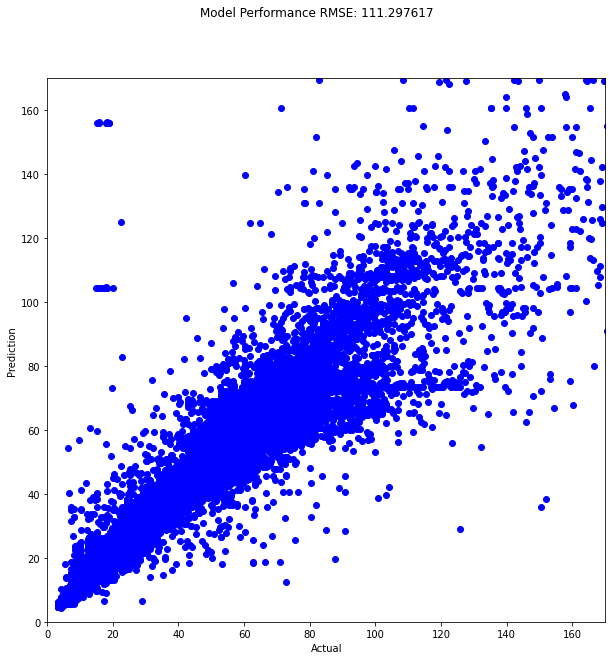

<Figure size 720x720 with 0 Axes>

In [0]:
# plot 
#restrict axis to 170

import matplotlib.pyplot as plt
import pandas as pd

plt.rcParams["figure.figsize"] = (10,10)

predictions_small_df = test_predictions_clear_small.toPandas()
plt.plot(predictions_small_df.label, predictions_small_df.prediction, 'bo')
plt.xlim([0, 170])
plt.ylim([0, 170])
plt.xlabel('Actual')
plt.ylabel('Prediction')
plt.show()
